## Code for data compilation

This file contains code:
- to simulate in-and-out-of-plane periodic pulsatile flow motion in a Shepp-Logan phantom
- for the designed sampling scheme across multiple frames, to be averaged to obtain image with minimal motion artefacts
- to generate mean standard error (MSE) vs TR spacing graph

In [1]:
import numpy as np
import sigpy as sp
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interactive
from IPython.display import display
from PIL import Image
import csv
import os

### 0. Functions

In [2]:
def shift_2d_array(arr_in, rl_shift, ud_shift):
#input: arr_in (input array), rl_shift (shift to right(+ve)/left(-ve) by how many pixels), ud_shift (shift upwards(+ve)/downwards(-ve) by how many pixels)
    rows, cols = arr_in.shape #get array size
    
    shifted_array_vertical = np.roll(arr_in, ud_shift, axis=0) #vertical shift
    
    arr_out = np.roll(shifted_array_vertical, rl_shift, axis=1) #horizontal shift
    
    return np.array(arr_out, dtype = float)

In [3]:
def segment_image(img_in, lower_threshold, upper_threshold):
    
    lower_mask = (img_in >= lower_threshold).astype(np.uint8)
    upper_mask = (img_in <= upper_threshold).astype(np.uint8)
    
    binary_mask = np.logical_and(lower_mask, upper_mask).astype(np.uint8) # Combine the masks to get the final binary mask
    
    segmented_image = img_in * binary_mask # Segment out the pixels with the specified intensity range
    
    non_segmented_image = img_in * (1 - binary_mask)  # Invert the binary mask to get the pixels outside the specified range
    
    return segmented_image, non_segmented_image, binary_mask

In [4]:
def get_phase_modulation(readout_num, TR, cardiac_cycle, phase_oscillation_amplitude):
    t = readout_num * TR #time
    
    #------ sinusoidal model ------
    
#     phase_modulation = phase_oscillation_amplitude * np.sin(2 * np.pi / cardiac_cycle * t)
    
    #------ sinusoidal model ------
    
    #------ more realistic model ------
    
    phase_modulation = (64.5
    - (5.154 * np.cos(2 * np.pi / cardiac_cycle * t) - 10.962 * np.sin(2 * np.pi / cardiac_cycle * t))
    - (5.4516 * np.cos(2 * 2 * np.pi / cardiac_cycle * t) - 1.7574 * np.sin(2 * 2 * np.pi / cardiac_cycle * t))
    - (1.731 * np.cos(3 * 2 * np.pi / cardiac_cycle * t) + 0.846 * np.sin(3 * 2 * np.pi / cardiac_cycle * t))
    - (1.5684 * np.cos(4 * 2 * np.pi / cardiac_cycle * t) + 0.23976 * np.sin(4 * 2 * np.pi / cardiac_cycle * t))
    - (0.50328 * np.cos(5 * 2 * np.pi / cardiac_cycle * t) + 1.0524 * np.sin(5 * 2 * np.pi / cardiac_cycle * t))
    - (0.10014 * np.cos(6 * 2 * np.pi / cardiac_cycle * t) + 0.30504 * np.sin(6 * 2 * np.pi / cardiac_cycle * t))
    - (0.035316 * np.cos(7 * 2 * np.pi / cardiac_cycle * t) + 0.3963 * np.sin(7 * 2 * np.pi / cardiac_cycle * t))
    + (0.16248 * np.cos(8 * 2 * np.pi / cardiac_cycle * t) - 0.17118 * np.sin(8 * 2 * np.pi / cardiac_cycle * t))
    )/33
    
    #------ more realistic model ------
    
    
    
    return phase_modulation

In [5]:
def get_modulated_kspace_line(segment_kspace_line_in, non_segment_kspace_line_in ,phase_modulation):
    
    segment_modulated_kspace_line = (segment_kspace_line_in * np.exp(1j * phase_modulation)).astype(np.complex128)
    modulated_kspace_line = (segment_modulated_kspace_line + non_segment_kspace_line_in).astype(np.complex128)
    return modulated_kspace_line.astype(np.complex128)

In [6]:
def get_mse(img1, img2):
    if img1.shape == img2.shape:
        img1 = img1
        img2 = img2
        mse_map = (img1 - img2) ** 2
    else:
        raise ValueError("Images must have the same dimensions")
    return mse_map

In [7]:
def quantify_artifacts(ground_truth, img_in):
    
    binary_mask = (ground_truth != 0).astype(np.uint8)
    
    gt_cumulative_intensity = np.sum(ground_truth) #cumulative intensity of ground truth
    ip_cumulative_intensity = np.sum(img_in * binary_mask) #in place cumulative intensity of image
    oop_cumulative_intensity = np.sum(img_in * (1 - binary_mask)) #out of place cumulative intensity of image
    
    ip_ratio = ip_cumulative_intensity/gt_cumulative_intensity
    oop_ratio = oop_cumulative_intensity/gt_cumulative_intensity
    
    return ip_ratio, oop_ratio #in place and out of place ratio

### 1. Motion Simulation

3D stack of images, additional time scale, 20 frames of images in 1 cardiac cycle, sample sequencially in k-space, then do inverse fourier transform

Displacement: sinusoidal approximation of motion

#### 1.1 Segmentation

In this part, the Shepp Logan phantom will be segmented into 2 images, with the segmented pixels representing the ones that experience motion, and the rest with no motion.

In [8]:
original_img = sp.shepp_logan([256,256], float)
print(np.unique(original_img))

lower_threshold = np.float64(0.299)
upper_threshold = np.float64(0.301)

lower_mask = (original_img >= lower_threshold).astype(np.uint8)
upper_mask = (original_img <= upper_threshold).astype(np.uint8)

segmented_img, non_segmented_img, binary_mask = segment_image(original_img, lower_threshold, upper_threshold)

[-5.55111512e-17  0.00000000e+00  2.00000000e-01  3.00000000e-01
  1.00000000e+00]


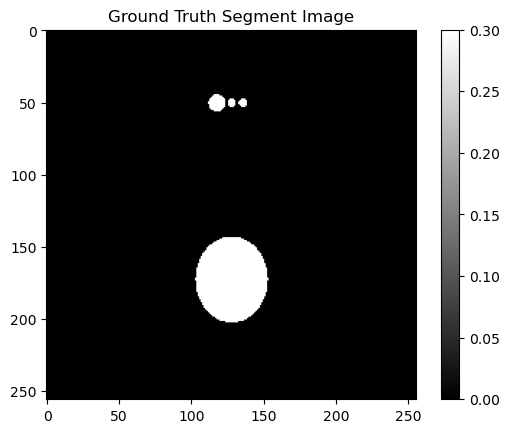

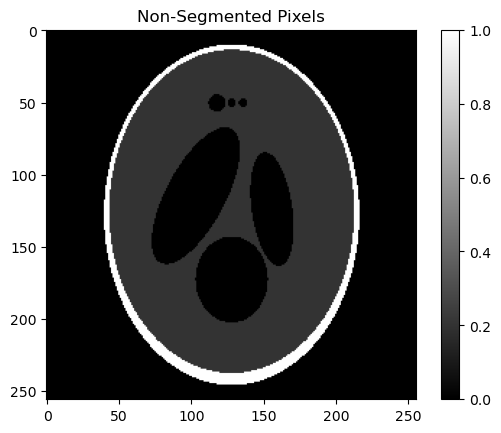

In [9]:
plt.figure()
plt.imshow(segmented_img, cmap='gray')
plt.title('Ground Truth Segment Image')
colorbar = plt.colorbar()

plt.figure()
plt.imshow(non_segmented_img, cmap='gray')
plt.title('Non-Segmented Pixels')
colorbar = plt.colorbar()

In [10]:
kspace_segmented_img = np.fft.fftshift(np.fft.fft2(segmented_img))
kspace_segmented_img_mag = np.log(np.abs(kspace_segmented_img) + 1)
kspace_segmented_img_phase = np.angle(kspace_segmented_img)

kspace_non_segmented_img = np.fft.fftshift(np.fft.fft2(non_segmented_img))
kspace_non_segmented_img_mag = np.log(np.abs(kspace_non_segmented_img) + 1)
kspace_non_segmented_img_phase = np.angle(kspace_non_segmented_img)

#### 1.2 Create Phase Modulation Train

The amplitude of oscillation should be a few pixels/voxels to reflect the pulses in the brain stem.

In [11]:
#Parameters
TR = 6/1000 #second
cardiac_cycle = 0.7 #second
phase_oscillation_amplitude = np.pi/8 #range: 0 - pi, the bigger, the more artefacts

n_TF = 12 #number of temporal frames that data will be sampled into

#### 1.3 Create csv file path

In [12]:
# Define the directory and file name
directory = '/Users/ellie/Desktop/FYP/Data'  # Replace with your target directory
file_name = 'output_hc' + str(cardiac_cycle) + '.csv' # MSE results file
# file_name = 'avg_phase_mod.csv' #phase modulation results file

# Ensure the directory exists
os.makedirs(directory, exist_ok=True)

# Construct the full file path
csv_file_path = os.path.join(directory, file_name)

# Write the header
with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    headers = ["TR spacing", "Phase modulation"]
    writer.writerow(headers)

#### 1.4 Apply reordered sampling scheme to visualise flow motion artefacts without correction

In [13]:
for TR_spacing in range(1, 257):
    readout_num = 0 #readout number, starting from zero
    
    #Initiate k-space arrays
    sampled_kspace = np.zeros((256,256,n_TF), dtype=np.complex128)
    sampled_kspace_mag = np.zeros((256,256,n_TF))
    sampled_kspace_phase = np.zeros((256,256,n_TF))

    sampled_kspace_seg = np.zeros((256,256,n_TF), dtype=np.complex128)
    sampled_kspace_seg_mag = np.zeros((256, 256, n_TF))
    sampled_kspace_seg_phase = np.zeros((256, 256, n_TF))
    
    phase_modulation_4vis = np.zeros((256, n_TF))
    
    #Sample data into k-space frames
    for frame in range(n_TF):
        for row in range(TR_spacing * (np.floor(np.shape(sampled_kspace_seg_phase)[0]/TR_spacing).astype(int) + 1)):
            PE_line = np.remainder(readout_num, TR_spacing).astype(int) + TR_spacing * np.floor(readout_num/(TR_spacing * n_TF)).astype(int)
            sample_into_frame = np.remainder(np.remainder(readout_num, TR_spacing) + np.floor((readout_num/TR_spacing)).astype(int),n_TF).astype(int)

            if PE_line < np.shape(kspace_segmented_img)[0]:
                phase_modulation = get_phase_modulation(readout_num, TR, cardiac_cycle, phase_oscillation_amplitude)
                phase_modulation_4vis[PE_line, sample_into_frame] = phase_modulation
                sampled_kspace[PE_line,:,sample_into_frame] = get_modulated_kspace_line(kspace_segmented_img[PE_line], kspace_non_segmented_img[PE_line] ,phase_modulation)

            
#             avg_phase_mod = np.mean(phase_modulation_4vis, axis = 1)

# ---------temporarily commented---------                
                
                
    #             print('PE line '+ str(PE_line) + ' sampled into frame ' + str(sample_into_frame))

    #         else:
    #             print('PE line '+ str(PE_line) + ' discarded for frame ' + str(sample_into_frame))

            readout_num += 1
    
    #Initialise image space arrays
    sampled_img = np.zeros((256,256,n_TF))
    
    #Transform k-space data into image space
    for frame in range(n_TF):
        sampled_img[:,:,frame] = np.abs(np.fft.ifftn(sampled_kspace[:,:,frame]))
        sampled_kspace_mag[:,:,frame] = np.log(np.abs(sampled_kspace)[:,:,frame] + 1)
        sampled_kspace_phase[:,:,frame] = np.angle(sampled_kspace[:,:,frame])
    
    #Obtain average k-space and image
    avg_kspace = np.mean(sampled_kspace,axis=2)
    avg_img = np.abs(np.fft.ifftn(avg_kspace))
    
    #Obtain mean standard error (MSE) of obtained image compared to original image
    mse_map = get_mse(avg_img, original_img)
    
    #Mask regions beyond region of interest (ROI)
    mse_seg_wo_flow = mse_map * (1-binary_mask)
    
    #Calculate MSE sum across the whole image
    MSE_seg_sum = np.sum(mse_seg_wo_flow)
    MSE_sum = np.sum(mse_map)
    
    # ---------temporarily commented---------  
    
    with open(csv_file_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([TR_spacing, MSE_seg_sum, MSE_sum])
 
    # ---------temporarily commented---------  
    with open(csv_file_path, mode='a', newline='') as file:
        writer = csv.writer(file)
#         writer.writerow(np.insert(avg_phase_mod, 0, TR_spacing))
    

print('Finished session')

Finished session
